In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Example: Extracellular current stimulation #
This is an example of **``LFPy``** running in an **``IPython notebook``**. To run through this example code and produce output, press **``<shift-Enter>``** in each code block below.

First step is to **import ``LFPy``** and other packages for analysis and plotting:

In [2]:
import numpy as np
import sys
if sys.version < '3':
    from urllib2 import urlopen
else:    
    from urllib.request import urlopen
import ssl
from warnings import warn
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy
import neuron

## Fetch model files

In [3]:
# Hay et al. 2011 pyramidal model

if not os.path.isfile('L5bPCmodelsEH/morphologies/cell1.asc'):
    # get the model files:
    u = urlopen('http://senselab.med.yale.edu/ModelDB/eavBinDown.asp?o=139653&a=23&mime=application/zip',
                context=ssl._create_unverified_context())
    localFile = open('L5bPCmodelsEH.zip', 'wb')
    localFile.write(u.read())
    localFile.close()
    #unzip:
    myzip = zipfile.ZipFile('L5bPCmodelsEH.zip', 'r')
    myzip.extractall('.')
    myzip.close()

# compile mod files every time, because of incompatibility with Mainen96 files:
if "win32" in sys.platform:
    pth = "L5bPCmodelsEH/mod/"
    warn("no autompile of NMODL (.mod) files on Windows.\n" 
         + "Run mknrndll from NEURON bash in the folder L5bPCmodelsEH/mod and rerun example script")
    if not pth in neuron.nrn_dll_loaded:
        neuron.h.nrn_load_dll(pth+"nrnmech.dll")
    neuron.nrn_dll_loaded.append(pth)
else:
    os.system('''
              cd L5bPCmodelsEH/mod/
              nrnivmodl
              ''')
    neuron.load_mechanisms('L5bPCmodelsEH/mod/')

In [4]:
# define cell parameters used as input to cell-class
cellParameters = {
    'morphology'    : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'templatefile'  : ['L5bPCmodelsEH/models/L5PCbiophys3.hoc',
                       'L5bPCmodelsEH/models/L5PCtemplate.hoc'],
    'templatename'  : 'L5PCtemplate',
    'templateargs'  : 'L5bPCmodelsEH/morphologies/cell1.asc',
    'passive' : False,
    'nsegs_method' : None,
    'dt' : 2**-6,
    'tstart' : -159,
    'tstop' : 10,
    'v_init' : -60,
    'celsius': 34,
    'pt3d' : True,
    'extracellular': True,
}

## Simulation of generator cell

In [5]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# initialize cell instance, using the LFPy.Cell class
generator_cell = LFPy.TemplateCell(**cellParameters) 
generator_cell.set_rotation(x=4.729, y=-3.166)

# override passive reversal potential, so AP is generated
for sec in generator_cell.allseclist:
    for seg in sec:
        seg.e_pas = -59.5


# place electrodes at each segment of the cell
# define parameters for extracellular recording electrode, using optional method
electrodeParameters = {
    'sigma' : 0.3,                  # extracellular conductivity
    # x,y,z-coordinates of contacts (from the grid in xz-plane over which we calculate local field potentials)
    'x' : generator_cell.xmid+100,  # + distance of the electrodes to the receptor cell
    'y' : generator_cell.ymid,
    'z' : generator_cell.zmid,
    'method' : 'soma_as_point',  #sphere source soma segment
    'N' : np.array([[0, 1, 0]]*generator_cell.xmid.size), #surface normals
    'r' : 2.5,              # contact site radius
    'n' : 20,               # datapoints for averaging
}

# create extracellular electrode object for LFPs on grid
electrode = LFPy.RecExtElectrode(**electrodeParameters)

# perform NEURON simulation of the generator cell
# results saved as attributes in the cell instance
generator_cell.simulate(electrode = electrode)

## Simulation of receptor cell

In [6]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

# initialize cell instance, using the LFPy.Cell class
receptor_cell = LFPy.TemplateCell(**cellParameters)
receptor_cell.set_rotation(x=4.729, y=-3.166)
receptor_cell.xmid += 100   # adjust distance 

# time of extracellular field simulation
t = np.arange(electrode.LFP.shape[1]) * receptor_cell.dt

# insert external field generated by the generator cell recorded in electrodes
receptor_cell.insert_v_ext(electrode.LFP, t)

# perform NEURON simulation of the receptor cell
receptor_cell.simulate(rec_vmem=True)

Overwriting custom temperature of 34.00. New temperature is 34.00


In [7]:
# find index positions of electrodes in the cells
positions = np.array(list(zip(generator_cell.xmid, generator_cell.zmid)))

target = np.array([200,200])     # estimated location in the plot
target_index = ((positions - target)**2).sum(axis=1).argmin()      # find closest electrode

target_pos = positions[target_index]    # find target electrode index

## Plotting

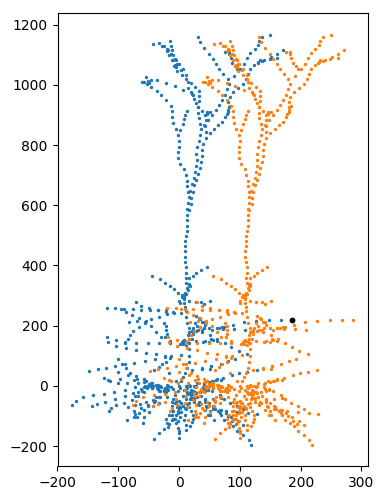

In [8]:
# plot neurons
plt.figure(dpi=100,
          figsize=(4,6))

plt.scatter(generator_cell.xmid, generator_cell.zmid,s=2)
plt.scatter(receptor_cell.xmid, receptor_cell.zmid,s=2)

# plot target electrode
plt.scatter(target_pos[0],target_pos[1],s=10,color='k')

Text(0.5,0,'Time')

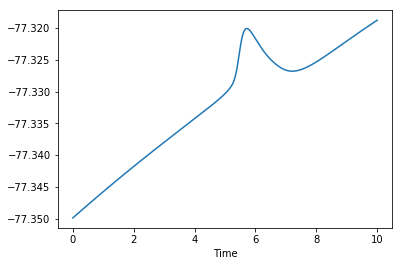

In [15]:
# plot membrane potential of receptor cell at a given location 
plt.plot(t,receptor_cell.vmem[40])
plt.xlabel("Time")

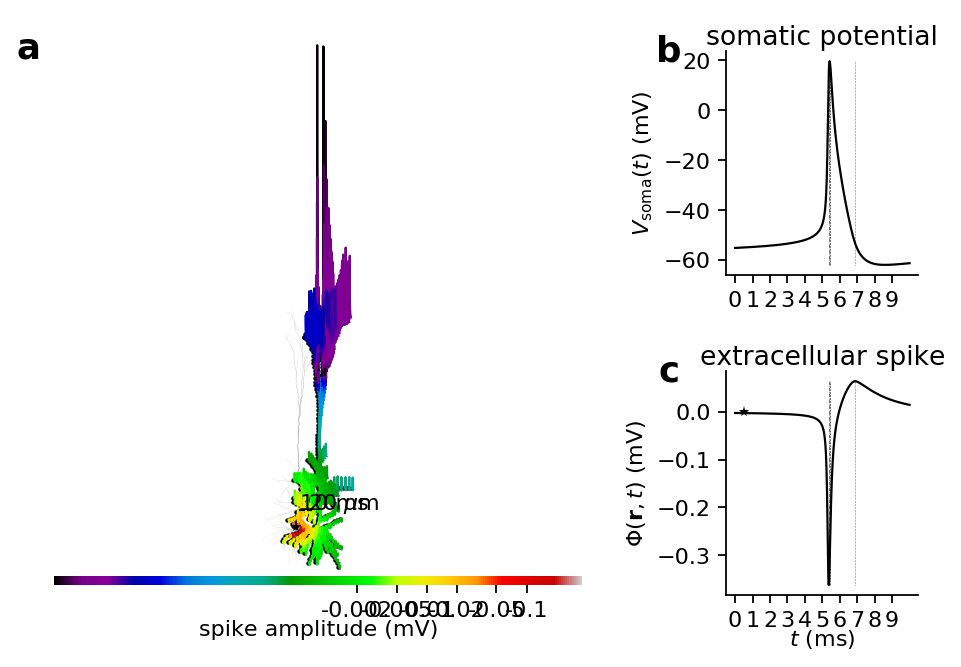

In [21]:
# plot generator cell

def plotstuff(generator_cell, electrode):
    fig = plt.figure(dpi=160)
    
    ax1 = fig.add_axes([0.05, 0.1, 0.55, 0.9], frameon=False)
    cax = fig.add_axes([0.05, 0.115, 0.55, 0.015])
    
    ax1.plot(electrode.x, electrode.z, '.', marker='o', markersize=1, color='k',
             zorder=0)
    
    #normalize to min peak
    LFPmin = electrode.LFP.min(axis=1)
    LFPnorm = -(electrode.LFP.T / LFPmin).T
    
    i = 0
    zips = []
    for x in LFPnorm:
        zips.append(list(zip(generator_cell.tvec*1.6 + electrode.x[i] + 2,
                        x*12 + electrode.z[i])))
        i += 1
    
    line_segments = LineCollection(zips,
                                    linewidths = (1),
                                    linestyles = 'solid',
                                    cmap='nipy_spectral',
                                    zorder=1,
                                    rasterized=False)
    line_segments.set_array(np.log10(-LFPmin))
    ax1.add_collection(line_segments)
    
    axcb = fig.colorbar(line_segments, cax=cax, orientation='horizontal')
    axcb.outline.set_visible(False)
    xticklabels = np.array([-0.1  , -0.05 , -0.02 , -0.01 , -0.005, -0.002])
    xticks = np.log10(-xticklabels)
    axcb.set_ticks(xticks)
    axcb.set_ticklabels(np.round(-10**xticks, decimals=3))  
    axcb.set_label('spike amplitude (mV)', va='center')
    
    ax1.plot([22, 38], [100, 100], color='k', lw = 1)
    ax1.text(22, 102, '10 ms')
    
    ax1.plot([60, 80], [100, 100], color='k', lw = 1)
    ax1.text(60, 102, '20 $\mu$m')
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    axis = ax1.axis(ax1.axis('equal'))
    ax1.set_xlim(axis[0]*1.02, axis[1]*1.02)
    
    # plot morphology
    zips = []
    for x, z in generator_cell.get_pt3d_polygons():
        zips.append(list(zip(x, z)))
    from matplotlib.collections import PolyCollection
    polycol = PolyCollection(zips, edgecolors='none',
                             facecolors='gray', zorder=-1, rasterized=False)
    ax1.add_collection(polycol)

    ax1.text(-0.05, 0.95, 'a',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=16, fontweight='demibold',
        transform=ax1.transAxes)
    

    # plot extracellular spike in detail
    ind = np.where(electrode.LFP == electrode.LFP.min())[0][0]
    timeind = (generator_cell.tvec >= 0) & (generator_cell.tvec <= 10)
    xticks = np.arange(10)
    xticklabels = xticks
    LFPtrace = electrode.LFP[ind, ]
    vline0 = generator_cell.tvec[generator_cell.somav==generator_cell.somav.max()]
    vline1 = generator_cell.tvec[LFPtrace == LFPtrace.min()]
    vline2 = generator_cell.tvec[LFPtrace == LFPtrace.max()]
    
    # plot asterix to link trace in (a) and (c)
    ax1.plot(electrode.x[ind], electrode.z[ind], '*', markersize=5, 
             markeredgecolor='none', markerfacecolor='k')
    
    ax2 = fig.add_axes([0.75, 0.6, 0.2, 0.35], frameon=True)
    ax2.plot(generator_cell.tvec[timeind], generator_cell.somav[timeind], lw=1, color='k', clip_on=False)
    
    ax2.vlines(vline0, generator_cell.somav.min(), generator_cell.somav.max(), 'k', 'dashed', lw=0.25)
    ax2.vlines(vline1, generator_cell.somav.min(), generator_cell.somav.max(), 'k', 'dashdot', lw=0.25)
    ax2.vlines(vline2, generator_cell.somav.min(), generator_cell.somav.max(), 'k', 'dotted', lw=0.25)
    
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticks)
    ax2.axis(ax2.axis('tight'))
    ax2.set_ylabel(r'$V_\mathrm{soma}(t)$ (mV)')
    
    for loc, spine in ax2.spines.items():
        if loc in ['right', 'top']:
            spine.set_color('none')            
    ax2.xaxis.set_ticks_position('bottom')
    ax2.yaxis.set_ticks_position('left')
    
    ax2.set_title('somatic potential', va='center')

    ax2.text(-0.3, 1.0, 'b',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=16, fontweight='demibold',
        transform=ax2.transAxes)

    ax3 = fig.add_axes([0.75, 0.1, 0.2, 0.35], frameon=True)
    ax3.plot(generator_cell.tvec[timeind], LFPtrace[timeind], lw=1, color='k', clip_on=False)
    ax3.plot(0.5, 0, '*', markersize=5, markeredgecolor='none', markerfacecolor='k')

    ax3.vlines(vline0, LFPtrace.min(), LFPtrace.max(), 'k', 'dashed', lw=0.25)
    ax3.vlines(vline1, LFPtrace.min(), LFPtrace.max(), 'k', 'dashdot', lw=0.25)
    ax3.vlines(vline2, LFPtrace.min(), LFPtrace.max(), 'k', 'dotted', lw=0.25)

    ax3.set_xticks(xticks)
    ax3.set_xticklabels(xticks)
    ax3.axis(ax3.axis('tight'))
    
    for loc, spine in ax3.spines.items():
        if loc in ['right', 'top']:
            spine.set_color('none')            
    ax3.xaxis.set_ticks_position('bottom')
    ax3.yaxis.set_ticks_position('left')

    ax3.set_xlabel(r'$t$ (ms)', va='center')
    ax3.set_ylabel(r'$\Phi(\mathbf{r},t)$ (mV)')
                   
    ax3.set_title('extracellular spike', va='center')

    ax3.text(-0.3, 1.0, 'c',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=16, fontweight='demibold',
        transform=ax3.transAxes)

    return fig

fig = plotstuff(generator_cell, electrode)

In [23]:
# plot receptor cell

# def plotting_function(cell, ext_field):
    
    ext_field = electrode.LFP
    
#     x0, y0, z0 = dbs_params['position']
#     amp = dbs_params['amp'] * 1000.
    
    ### PLOTTING THE RESULTS
    cell_plot_idxs = [0,  receptor_cell.get_closest_idx(x=-150., y=0, z=750.)]    
    cell_plot_colors = {cell_plot_idxs[idx]: plt.cm.Greens_r(1./(len(cell_plot_idxs) + 1) * idx + 0.1) 
                        for idx in range(len(cell_plot_idxs))}

    # Plotting the morphology
    plt.figure(figsize=(16,9))

    v_field_ext = np.zeros((50, 200))
    xf = np.linspace(np.min(receptor_cell.xend), np.max(receptor_cell.xend), 50)
    zf = np.linspace(np.min(receptor_cell.zend), np.max(receptor_cell.zend), 200)
    for xidx, x in enumerate(xf):
        for zidx, z in enumerate(zf):
            v_field_ext[xidx, zidx] = ext_field(x, 0, z) #* amp
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(121, aspect='equal', xlabel='x [$\mu m$]', ylabel='z [$\mu m$]', 
                xlim=[-400, 400], xticks=[-400, 0, 400], title='Green dots: Measurement points')
    plt.imshow(v_field_ext.T, extent=[np.min(receptor_cell.xend), np.max(receptor_cell.xend), np.min(receptor_cell.zend), np.max(receptor_cell.zend)], 
               origin='lower', interpolation='nearest', cmap=plt.cm.bwr_r, vmin=-150, vmax=150)

    plt.colorbar(label='mV')
    [plt.plot([receptor_cell.xstart[idx], receptor_cell.xend[idx]], [receptor_cell.zstart[idx], receptor_cell.zend[idx]], c='gray', zorder=1) 
     for idx in range(receptor_cell.totnsegs)]
    [plt.plot(receptor_cell.xmid[idx], receptor_cell.zmid[idx], 'o', c=cell_plot_colors[idx], ms=12) 
     for idx in cell_plot_idxs]
    
    l, = plt.plot(x0, z0, 'y*', ms=12)
    plt.legend([l], ["point current source"], frameon=False)

    # Plotting the membrane potentials
    plt.subplot(222, title='Membrane potential', xlabel='Time [ms]', ylabel='mV', ylim=[-80, 20])
    [plt.plot(receptor_cell.tvec, receptor_cell.vmem[idx, :], c=cell_plot_colors[idx], lw=2) for idx in cell_plot_idxs]

    
# plotting_function(receptor_cell, ext_field)

TypeError: 'numpy.ndarray' object is not callable